In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [15]:
data = pd.read_csv('../data/Kaggle_MBTI.csv')
data.shape

(8675, 2)

/Users/chenenying/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



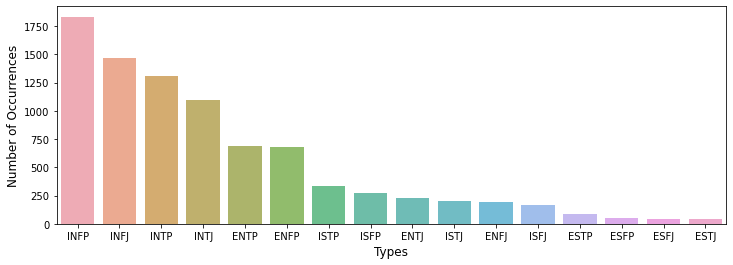

In [4]:
cnt_srs = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [7]:
cnt_srs

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [6]:
import plotly.express as px
px.pie(data, names='type', title='Personality type', hole=0.3)

In [7]:
"""測試用cell"""


"""
b = data.loc[0, 'posts']
a = data.loc[0,'type']


tokens = []
b = re.sub(r'\|\|\|', r"    ", b)    # 去除'|||'
b = re.sub(r'http\S+', r' ', b)    # 去除網址
b = re.sub('INTJ|intj|INTP|intp|ENTJ|entj|ENTP|entp|INFP|infp|ENFJ|enfj|ENFP|enfp|ISTJ|istj|ISFJ|isfj|ESTJ|estj|ESFJ|esfj|ISTP|istp|ISFP|isfp|ESTP|estp|ESFP|esfp|INFJ|infj','',b)
b = re.sub(r'\d','', b)  # 去除數字

# 取出所有格 -> 放入列表 -> 去除所有格
x = re.findall("[A-Za-z]+\'+\w+", b)   # 找出所有格
for i in x:
    tokens.append(i)
tokens
b = re.sub(r"[A-Za-z]+\'+\w+", r"   ", b)  # 去除所有格
#print(b)


pattern = r"\w+"      # 定義pattern
result = re.findall( pattern , b )  # tokenizaion
#print(result)
for i in result:
    tokens.append(i)
# tokens
"""

### Case1 : Remove all MBTI results within the posts

In [16]:
# 存放結果之 dictionary
dictionary_removeMBTI = {   "INTJ":[],
    "INTP":[],
    "ENTJ":[],
    "ENTP":[],
    "INFP":[],
    "ENFJ":[],
    "ENFP":[],
    "ISTJ":[],
    "ISFJ":[],
    "ESTJ":[],
    "ESFJ":[],
    "ISTP":[],
    "ISFP":[],
    "ESTP":[],
    "ESFP":[],
    "INFJ":[],
}

# tokenize後的dataframe
dataframe_for_removeMBTI = data.copy()

In [17]:
for d in range(len(data)):
    post = data.loc[d, 'posts']

    tokens = []
    post = re.sub(r'\|\|\|', r"    ", post)    # 去除'|||'
    post = re.sub(r'http\S+', r' ', post)    # 去除網址
    post = re.sub('INTJ|intj|INTP|intp|ENTJ|entj|ENTP|entp|INFP|infp|ENFJ|enfj|ENFP|enfp|ISTJ|istj|ISFJ|isfj|ESTJ|estj|ESFJ|esfj|ISTP|istp|ISFP|isfp|ESTP|estp|ESFP|esfp|INFJ|infj','',post) #去除 post 中有提到 MBTI 結果的文字
    post = re.sub(r'\d','', post)  # 去除數字

    # 取出所有格 -> 放入列表 -> 去除所有格
    x = re.findall("[A-Za-z]+\'+\w+", post)   # x is a list
    for i in x:
        tokens.append(i)
    post = re.sub(r"[A-Za-z]+\'+\w+", r"   ", post)  # 去除所有格

    result = re.findall( r"\w+" , post )  # tokenizaion
    for i in result:
        tokens.append(i)
    
    # 整理回 dataframe
    dataframe_for_removeMBTI.posts[d] = tokens

    # 整理進 dictionary
    for token in tokens:
        dictionary_removeMBTI[data.loc[d,'type']].append(token)

In [18]:
dataframe_for_removeMBTI

,type,posts
0,INFJ,"[It's, don't, you've, There's, i'd, Don't, you..."
1,ENTP,"[I'm, it's, isn't, That's, don't, you're, you'..."
2,INTP,"[that's, it's, didn't, It's, you're, haven't, ..."
3,INTJ,"[I'd, he's, I'm, I'm, I'm, I'd, You're, didn't..."
4,ENTJ,"[You're, That's, C'mon, doesn't, wouldn't, tha..."
...,...,...
8670,ISFP,"[I'm, I've, I'm, they're, can't, You're, don't..."
8671,ENFP,"[didn't, You're, isn't, I've, That's, I'd, I'm..."
8672,INTP,"[you're, that's, arn't, I'm, I've, it's, it's,..."
8673,INFP,"[don't, don't, There's, won't, can't, I'm, don..."


In [7]:
len(dictionary_removeMBTI['INTJ'])

1333599

### Case2 : preserve all MBTI results

In [19]:
# 存放結果之 dictionary
dictionary_preserveMBTI = {   "INTJ":[],
    "INTP":[],
    "ENTJ":[],
    "ENTP":[],
    "INFP":[],
    "ENFJ":[],
    "ENFP":[],
    "ISTJ":[],
    "ISFJ":[],
    "ESTJ":[],
    "ESFJ":[],
    "ISTP":[],
    "ISFP":[],
    "ESTP":[],
    "ESFP":[],
    "INFJ":[],
}

# tokenize後的dataframe
dataframe_for_preserveMBTI = data.copy()

In [20]:
for d in range(len(dataframe_for_preserveMBTI)):
    post = dataframe_for_preserveMBTI.loc[d, 'posts']

    tokens = []
    post = re.sub(r'\|\|\|', r"    ", post)    # 去除'|||'
    post = re.sub(r'http\S+', r' ', post)    # 去除網址
    post = re.sub(r'\d','', post)  # 去除數字

    # 取出所有格 -> 放入列表 -> 去除所有格
    x = re.findall("[A-Za-z]+\'+\w+", post)   # x is a list
    for i in x:
        tokens.append(i)
    post = re.sub(r"[A-Za-z]+\'+\w+", r"   ", post)  # 去除所有格

    result = re.findall( r"\w+" , post )  # tokenizaion
    for i in result:
        tokens.append(i)
    
    # 整理回 dataframe
    dataframe_for_preserveMBTI.posts[d] = tokens

    # 整理進 dictionary
    for token in tokens:
        dictionary_preserveMBTI[data.loc[d,'type']].append(token)

In [22]:
dataframe_for_preserveMBTI

,type,posts
0,INFJ,"[It's, don't, you've, There's, i'd, Don't, you..."
1,ENTP,"[I'm, it's, isn't, That's, don't, you're, you'..."
2,INTP,"[that's, it's, didn't, It's, you're, haven't, ..."
3,INTJ,"[I'd, he's, I'm, I'm, I'm, I'd, You're, didn't..."
4,ENTJ,"[You're, That's, C'mon, doesn't, wouldn't, tha..."
...,...,...
8670,ISFP,"[I'm, I've, I'm, they're, can't, You're, don't..."
8671,ENFP,"[didn't, You're, isn't, I've, That's, I'd, I'm..."
8672,INTP,"[you're, that's, arn't, I'm, I've, it's, it's,..."
8673,INFP,"[don't, don't, There's, won't, can't, I'm, don..."


In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

def Preprocessor(text, stemmer='Snowball', remove_mbti=False):
    text = re.sub(r'\|\|\|', ' ', text)  # Split by separator
    text = re.sub(r'http\S+', ' ', text)  # Replace hyperlink
    text = re.sub(r"[A-Za-z]+\'+\w+", ' ', text)  # Handling apostrophe possessive (e.g.you've, there's)
    text = re.sub('[^0-9a-zA-Z]',' ', text)  # Remove special characters
    text = re.sub(' +', ' ', text)  # Remove redundant space
    text = text.lower()
    tokens = word_tokenize(text)  # Tokenization
    filtered_tokens = [w for w in tokens if not w in stop_words]  # Remove stopwords
    if remove_mbti == True:
        filtered_tokens = re.sub('intj|intp|entj|entp|infp|enfj|enfp|istj|isfj|estj|esfj|istp|isfp|estp|esfp|infj', '', filtered_tokens)
    stemmer = SnowballStemmer("english")
    lemma = WordNetLemmatizer()
    if stemmer == 'Porter':  # Select stemmer
        stemmer = PorterStemmer()
    stemmed = [stemmer_ps.stem(t) for t in filtered_tokens]
    lemmatized = [lemma.lemmatize(t) for t in stemmed]
    return lemmatized

In [43]:
import re

text ="\\\cmd\\\lru\\\enc"
print(text)

a = text.encode().decode( 'unicode escape').encode("raw unicode escape" )
# # a = re.sub(r'\\\\', r"\\", text) 
# a = text.replace('\\\\', '\\')
a

\\cmd\\lru\\enc


b'\\cmd\\lru\\enc'